# Seeing Beyond Statistics: Anscombe's Quartet and the Power of Graphs

<img align="right" width="320" height="240" src="anscombes-quartet.png">

In 1937, statistician Francis Anscombe challenged the commonly held belief that "numerical calculations are exact, but graphs are rough" (Anscombe, 1937).
His strategy was to manually construct four small datasets---now known as Anscombe's Quartet---that have different distributions but nearly identical descriptive statistics.
It's perhaps the best argument for visualizing data. 

In this notebook we replicate his paper by using Plotnine to visualize those datasets and Polars to verify their descriptive statistics.
More specifically, we:

- Turn the original values that Anscombe used into one long DataFrame
- Verify the descriptive statistics
- Create a couple of exploratory data visualizations
- Fine-tune the visualization to make it suitable for communication

In [1]:
import polars as pl
from plotnine import *

## Create a Long DataFrame

First, we turn the original four datasets into one Polars DataFrame.
With 3 columns and 44 rows, the DataFrame is in long format, making it convenient for Polars to compute descriptive statistics and for Plotnine to visualize each row as a point.
The column `dataset` indicates which rows belong to which dataset using the Roman numerals `I` through `IV`. (The Roman numerals are purely for visualization purposes.)

In [2]:
anscombe_datasets = [
    {"x": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
     "y": [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]},
    {"x": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
     "y": [9.14, 8.14, 8.74, 8.77, 9.26, 8.1, 6.13, 3.1, 9.13, 7.26, 4.74]},
    {"x": [10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0],
     "y": [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]},
    {"x": [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 19.0, 8.0, 8.0, 8.0],
     "y": [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.5, 5.56, 7.91, 6.89]}
]

anscombe_quartet = pl.concat([
    pl.DataFrame(xy).select(pl.lit(d).alias("dataset"), "x", "y")
    for d, xy in zip(["I", "II", "III", "IV"], anscombe_datasets)
])

anscombe_quartet

dataset,x,y
str,f64,f64
"""I""",10.0,8.04
"""I""",8.0,6.95
"""I""",13.0,7.58
"""I""",9.0,8.81
"""I""",11.0,8.33
…,…,…
"""IV""",8.0,5.25
"""IV""",19.0,12.5
"""IV""",8.0,5.56


## Compute Descriptive Statistics

To verify that the four datasets have identical descriptive statistics, we use Polars to compute the mean and the variance of both `x` and `y`. We also compute the correlation between `x` and `y`:

In [3]:
pl.Config.set_float_precision(2)

anscombe_quartet.group_by("dataset", maintain_order=True).agg(
    pl.col("x", "y").mean().name.prefix("mean_"),
    pl.col("x", "y").var().name.prefix("variance_"),
    pl.corr("x", "y").alias("correlation_xy"),
)

dataset,mean_x,mean_y,variance_x,variance_y,correlation_xy
str,f64,f64,f64,f64,f64
"""I""",9.00,7.50,11.00,4.13,0.82
"""II""",9.00,7.50,11.00,4.13,0.82
"""III""",9.00,7.50,11.00,4.12,0.82
"""IV""",9.00,7.50,11.00,4.12,0.82


As you can see, the descriptive statistics are nearly identical.
At the end of this notebook there's a bonus section where we use scikit-learn to fit a linear regression line to each dataset and verify that the intercept, slope, and $R^2$ are also identical. (Spoiler alert: they are!)

## Exploratory Data Visualization

Let's create a few basic data visualizations to get a better feeling for the data.
What's great about Plotnine is that you can get a first plot with relatively little code.
We have two continuous variables `x` and `y`, so a scatter plot might work:

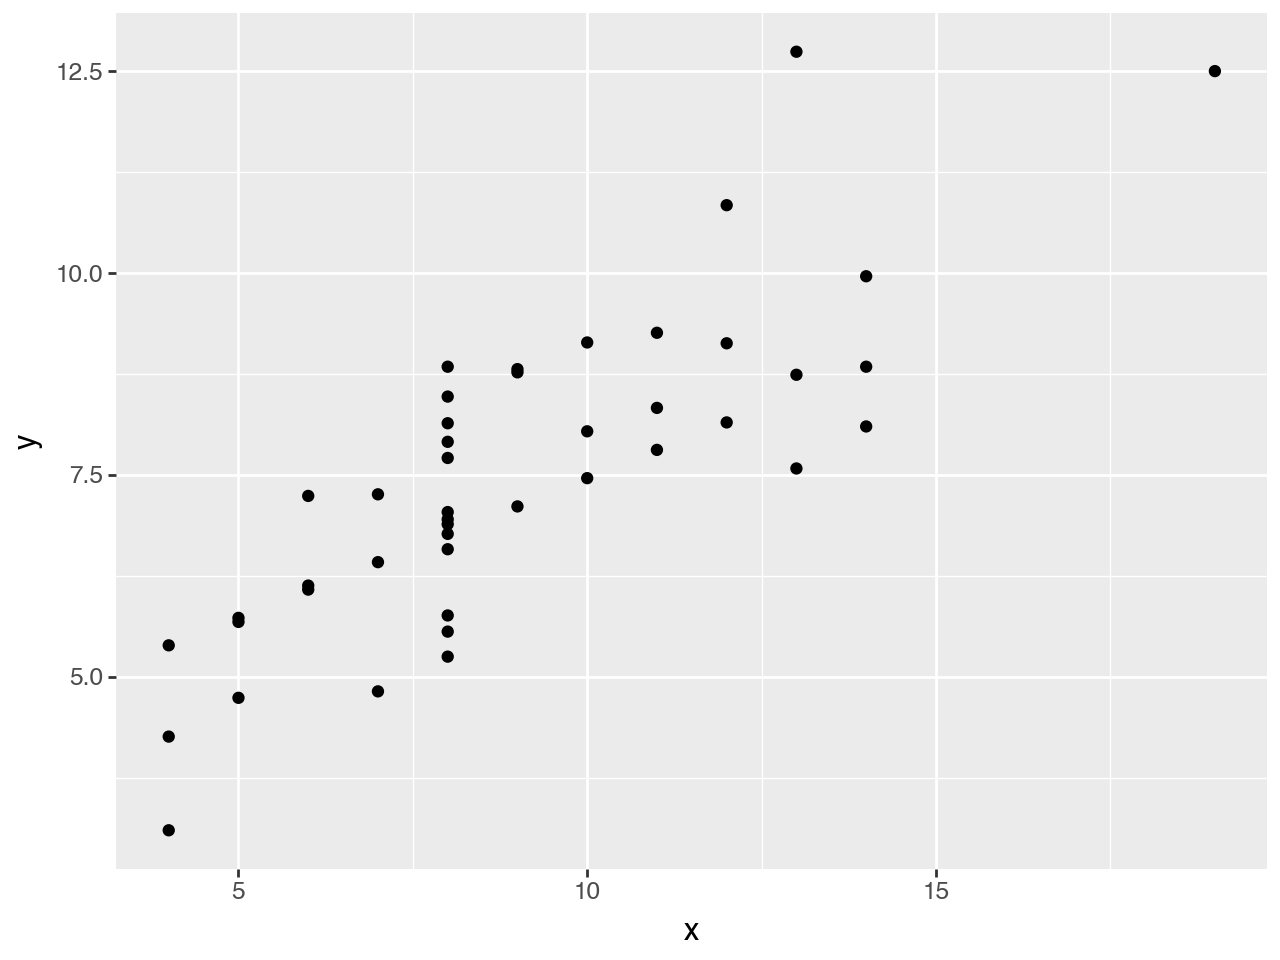

In [4]:
ggplot(anscombe_quartet, aes("x", "y")) + geom_point()

That doesn't make much sense yet.
We need a way to distinguish between the datasets.
Let's color each point according to the dataset it belongs to:

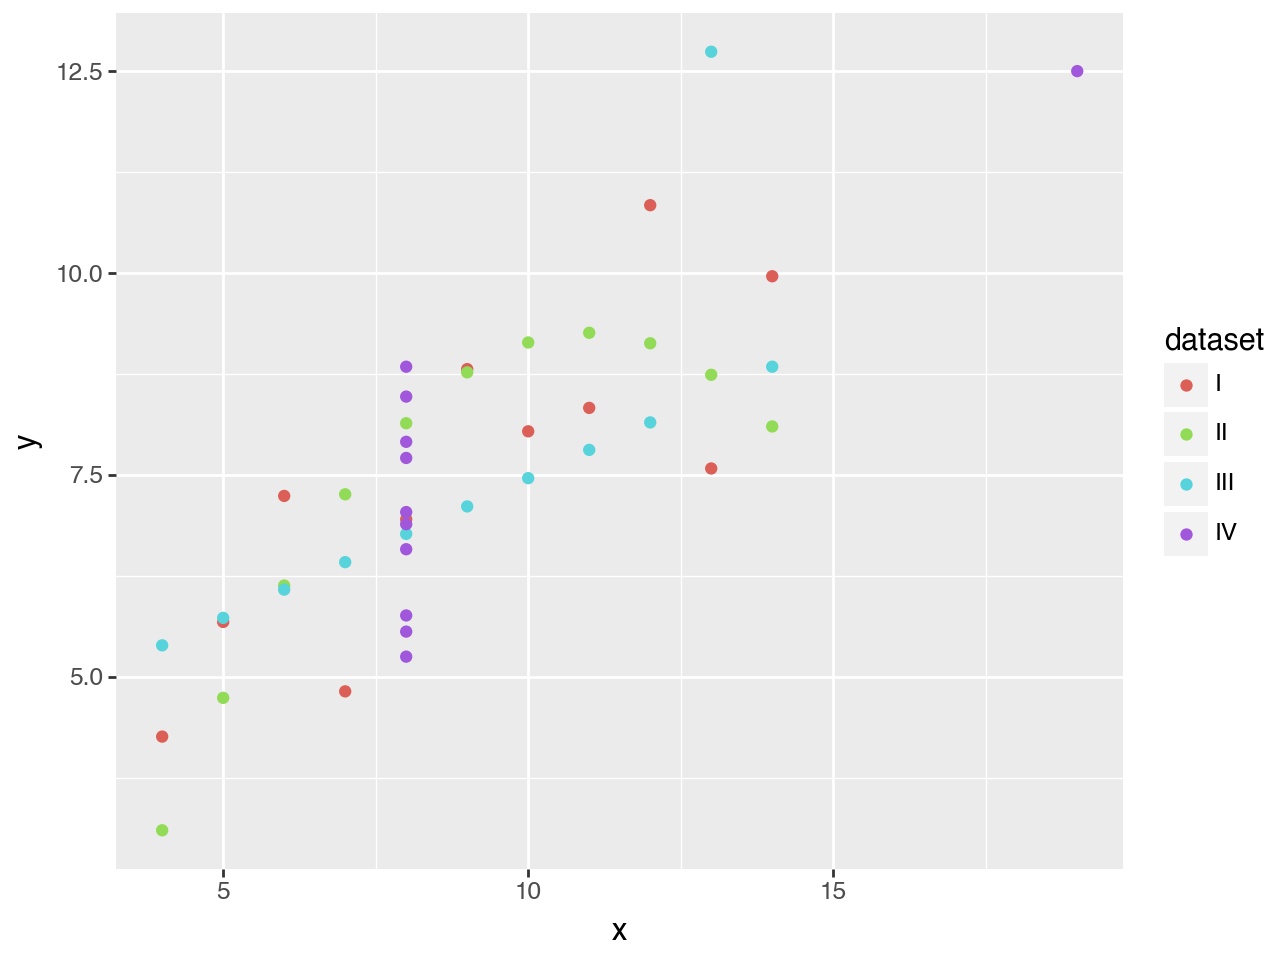

In [5]:
ggplot(anscombe_quartet, aes("x", "y", color="dataset")) + geom_point()

Well, that's rather messy. Let's create a panel for each dataset instead using the `facet_wrap()` function instead. To make the code easier to read and to edit, we'll put each function on its own line:

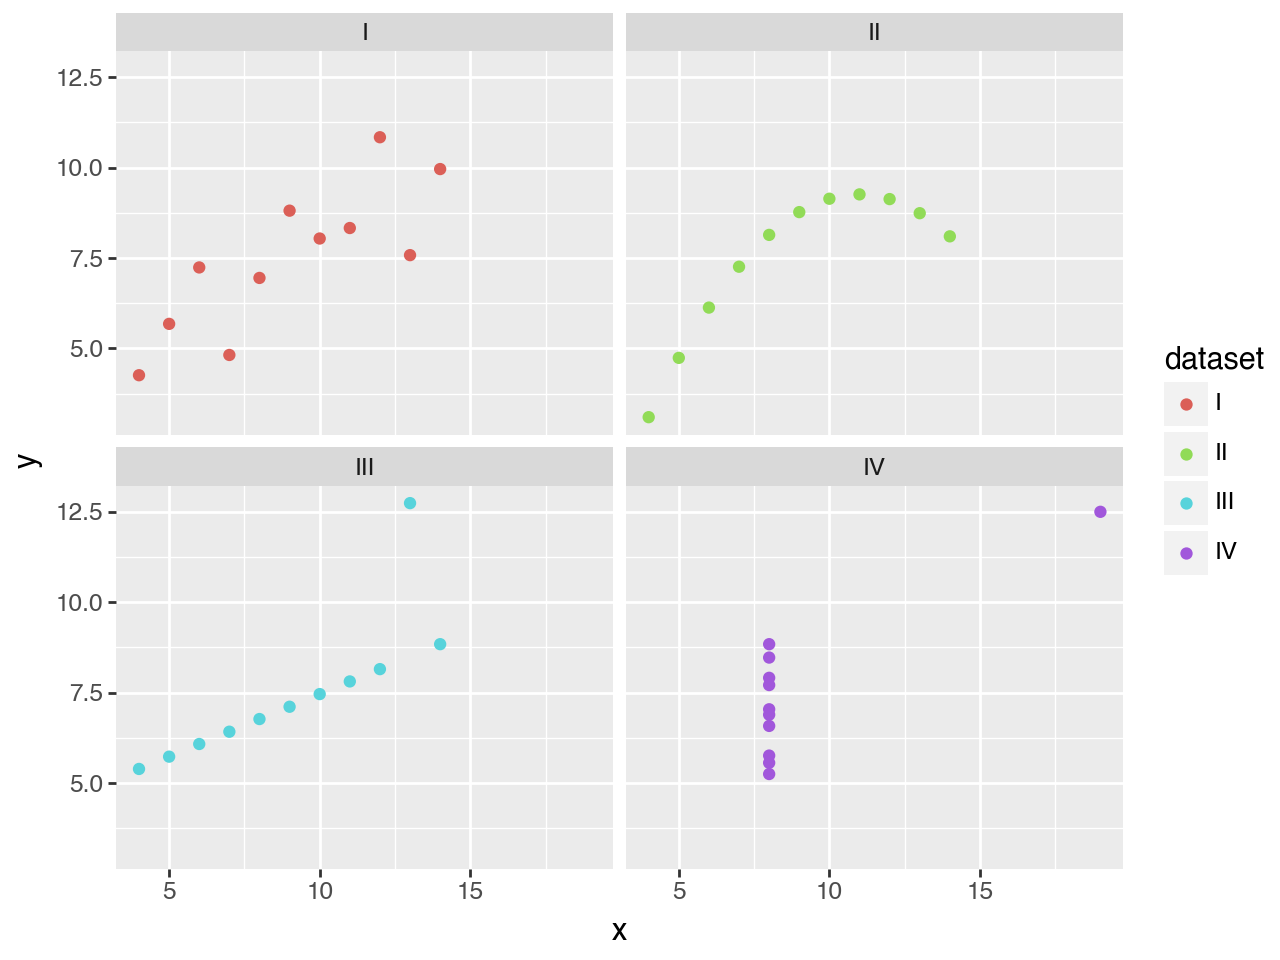

In [6]:
(
    ggplot(anscombe_quartet, aes("x", "y", color="dataset")) +
    facet_wrap("dataset") +
    geom_point()
)

That's better.
The panels make the use of color redundant, so we'll make each point black again.
Let's also add a regression line using the `geom_smooth()` function, to visualize that the four datasets have identical descriptive statistics. 

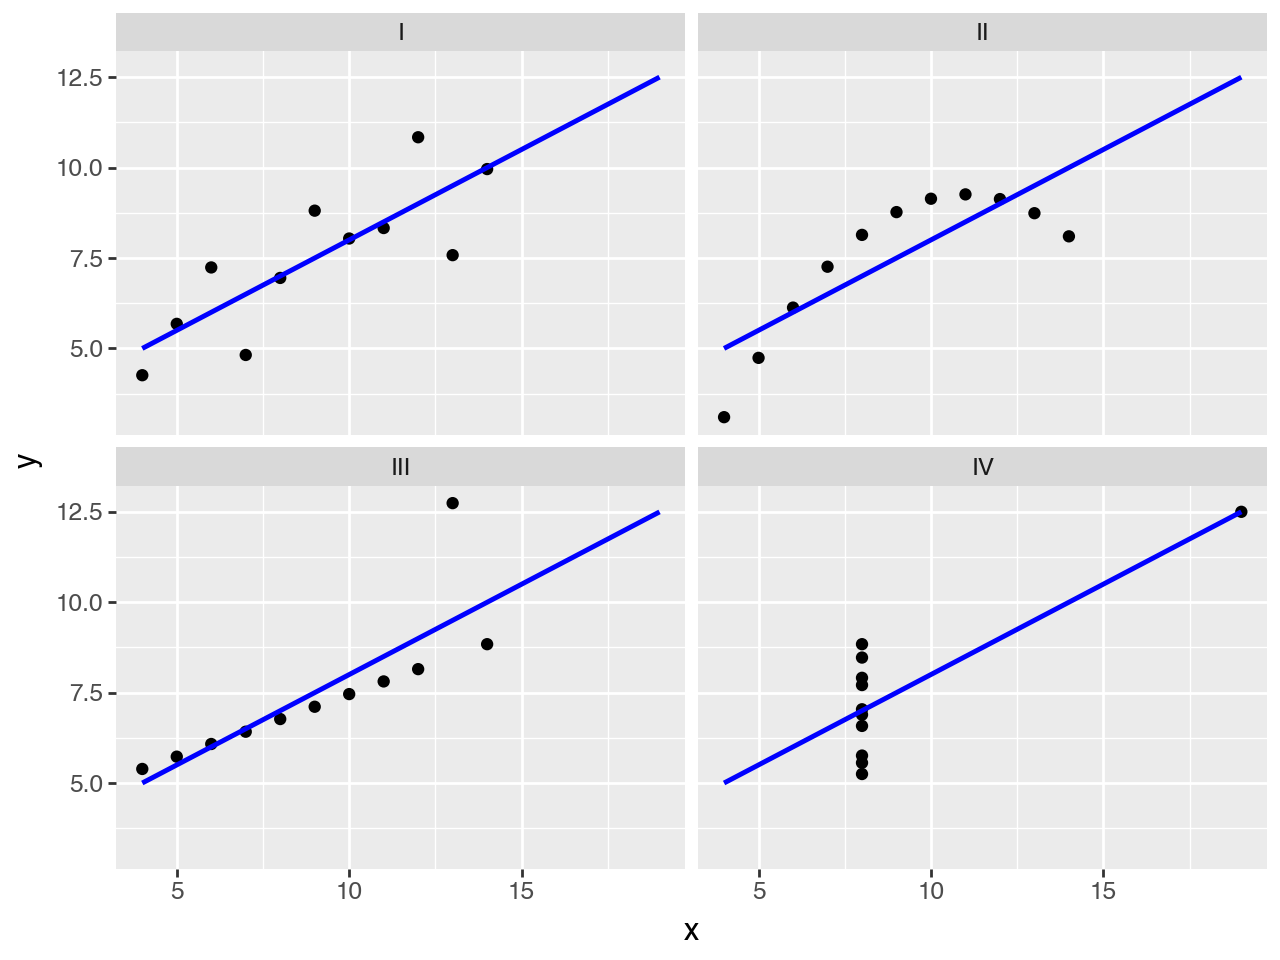

In [7]:
(
    ggplot(anscombe_quartet, aes("x", "y")) +
    geom_point() +
    geom_smooth(method="lm", se=False, fullrange=True, color="blue") +
    facet_wrap("dataset")
)

This data visualization clearly supports Anscombe's point: that datasets with different distributions can have the same descriptive statistics.

## A Fine-Tuned Data Visualization

Our final exploratory data visualization gets the job done, but it doesn't hurt to make it more visually appealing.
In the following code snippet, we:

* Remove many elements, including grid lines, tick marks, and axis labels. They're not needed to bring the point across.
* Add a title.
* Change the colors and the font.

As you can see, there's quite some code needed for this fine-tuning. 
Luckily, because of its composable API, Plotnine allows you to gradually move from a exploratory data visualization to a fine-tuned explanatory one. 

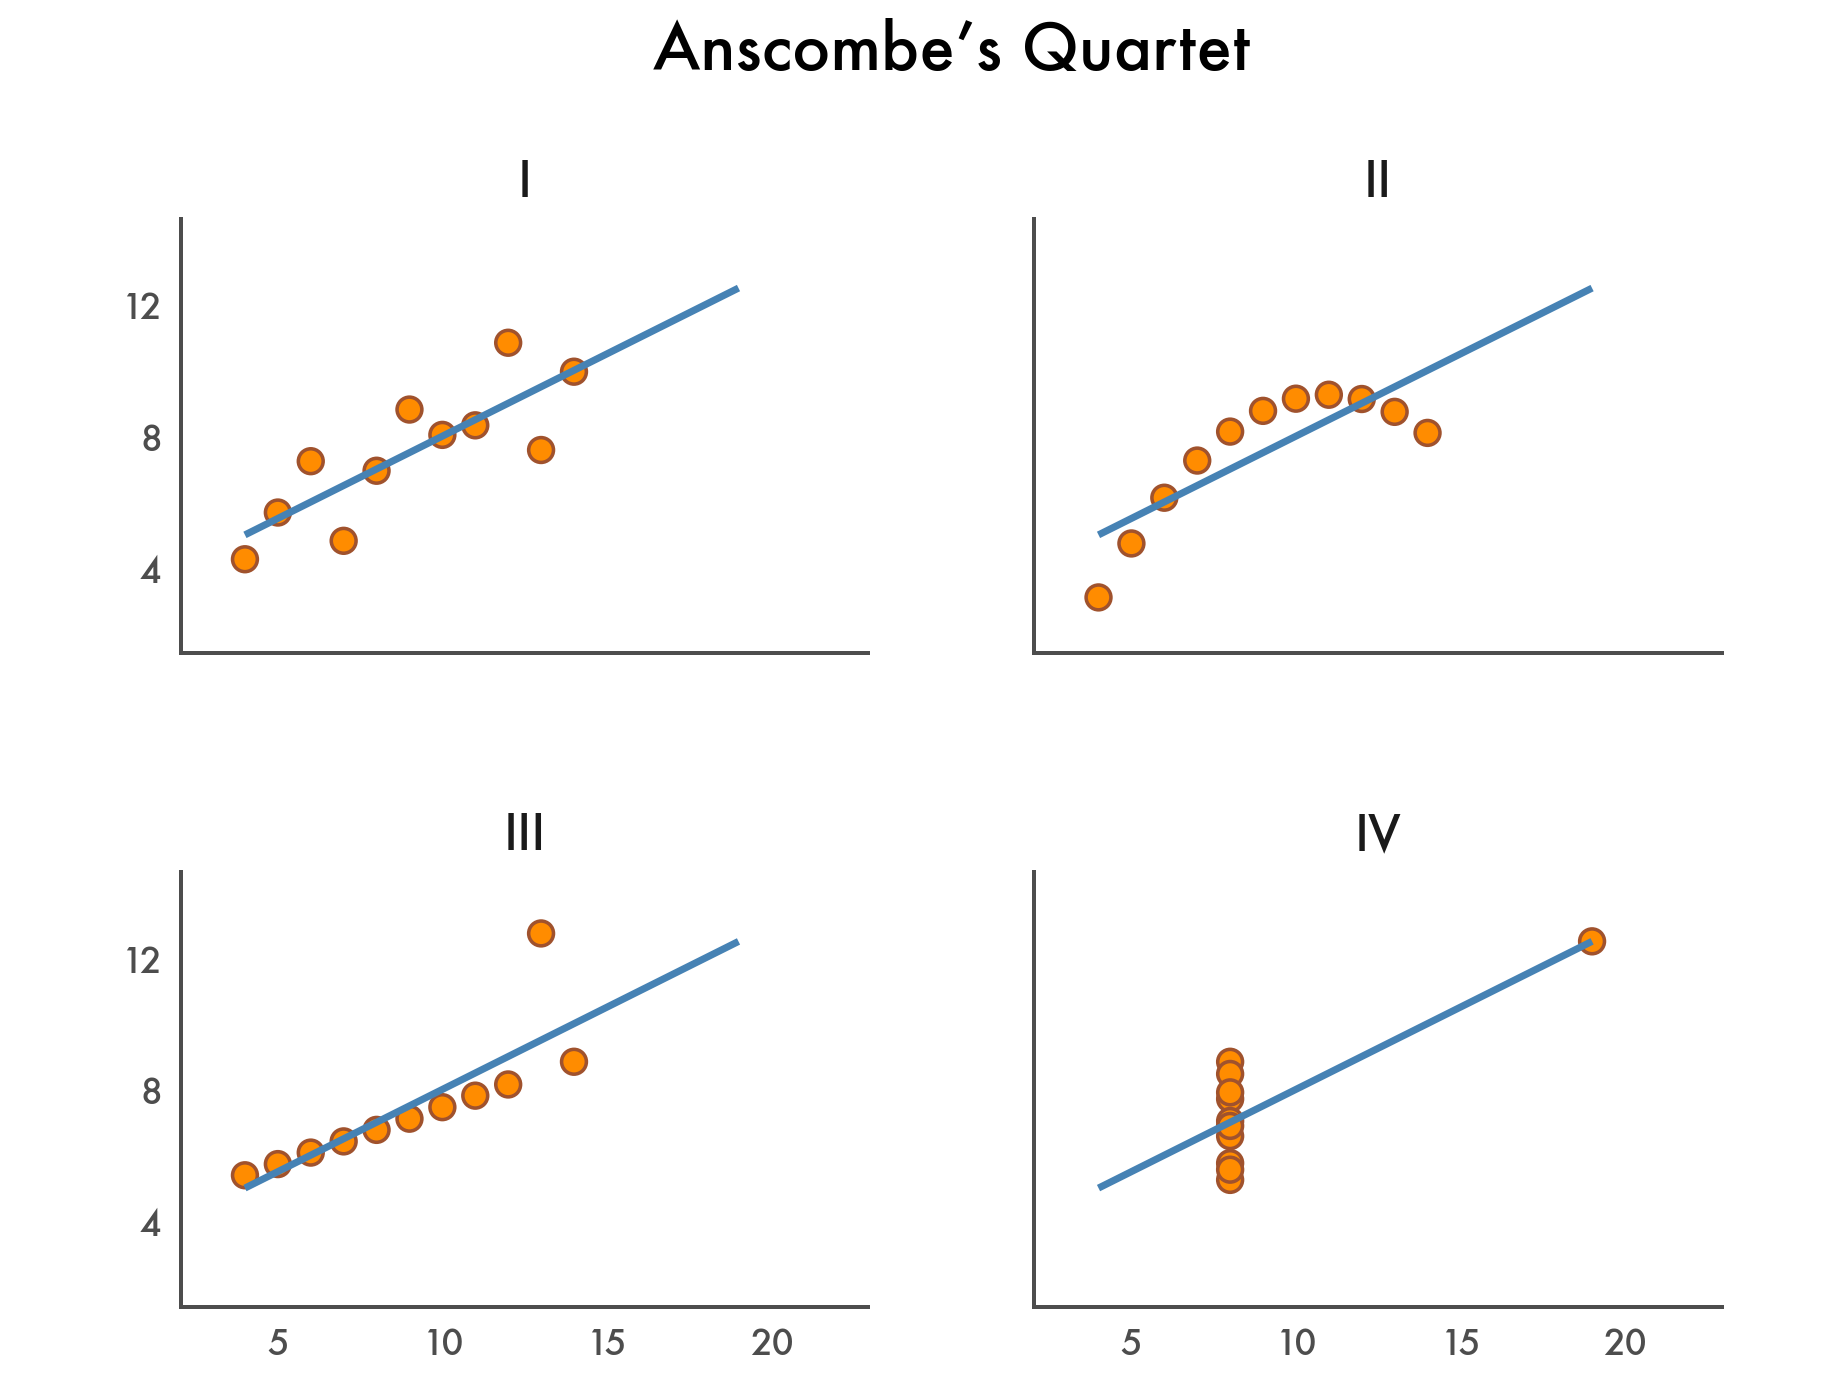

In [8]:
(
    ggplot(anscombe_quartet, aes("x", "y")) +
    geom_point(color="sienna", fill="darkorange", size=3) +
    geom_smooth(method="lm", se=False, fullrange=True, color="steelblue", size=1) +
    facet_wrap("dataset") +
    scale_y_continuous(breaks=(4, 8, 12)) +
    coord_fixed(xlim=(3, 22), ylim=(2, 14)) +
    labs(title="Anscombe’s Quartet") +
    theme_tufte(base_family="Futura") +
    theme(
        axis_line=element_line(color="#4d4d4d"),
        axis_ticks_major=element_line(color="#00000000"),
        axis_title=element_blank(),
        plot_background=element_rect(fill="#ffffff", color="#ffffff"),
        dpi=144,
        panel_spacing=0.09,
        strip_text=element_text(size=12),
        title=element_text(size=16, margin={"b": 20})
    )
)

In [9]:
_.save("anscombes-quartet.png")

/Users/jeroen/Library/Caches/pypoetry/virtualenvs/non-package-mode-zxCXwf2j-py3.12/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/jeroen/Library/Caches/pypoetry/virtualenvs/non-package-mode-zxCXwf2j-py3.12/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: anscombes-quartet.png


## Bonus: Apply Linear Regression

In this bonus section, we use scikit-learn to fit a linear regression line to each dataset and confirm that the intercept, slope, and $R^2$ are also identical.
The `geom_smooth()` function added regression lines to our scatter plots, but now we get to see the raw values as well.

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fit_lr(s):
    lr = LinearRegression()
    X = s.struct.field("x").to_numpy().reshape(-1, 1)
    y = s.struct.field("y").to_numpy()

    # Compute intercept and coefficient
    lr.fit(X, y)
    intercept = lr.intercept_
    slope = lr.coef_[0]

    # Compute R^2
    r2 = r2_score(y, intercept + slope * X)
    
    return {"intercept": intercept, "slope": slope, "r2": r2}

anscombe_quartet.group_by("dataset", maintain_order=True).agg(
    pl.col("x", "y").mean().name.prefix("mean_"),
    pl.col("x", "y").var().name.prefix("variance_"),
    pl.corr("x", "y").alias("correlation_xy"),
    (
        pl.struct("x", "y")
        .map_elements(fit_lr, return_dtype=pl.Struct({"intercept": pl.Float64,
                                                      "slope": pl.Float64,
                                                      "r2": pl.Float64}))
        .alias("lr")
    )
).unnest("lr")

dataset,mean_x,mean_y,variance_x,variance_y,correlation_xy,intercept,slope,r2
str,f64,f64,f64,f64,f64,f64,f64,f64
"""I""",9.00,7.50,11.00,4.13,0.82,3.00,0.50,0.67
"""II""",9.00,7.50,11.00,4.13,0.82,3.00,0.50,0.67
"""III""",9.00,7.50,11.00,4.12,0.82,3.00,0.50,0.67
"""IV""",9.00,7.50,11.00,4.12,0.82,3.00,0.50,0.67


## References

* Anscombe, F. J. (1973). "Graphs in Statistical Analysis". American Statistician. 27 (1): 17–21. 